In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
weather = pd.read_csv("../Weather/Weather.csv")
weather = weather.drop(columns=["%time"])
resource = pd.read_csv("../AICU/Resources.csv")
test_resource = pd.read_csv("../TheAutomators/Resources.csv")
climate = pd.read_csv("../AICU/GreenhouseClimate.csv",encoding='utf-8')
test_climate = pd.read_csv("../TheAutomators/GreenhouseClimate.csv",encoding='utf-8')
production = pd.read_csv("../TheAutomators/Production.csv",encoding='utf-8')
production = production.astype(float)
climate=climate.astype(float)



C:\Users\thanh\AppData\Local\Temp\ipykernel_27456\1784020480.py:5: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  climate = pd.read_csv("../AICU/GreenhouseClimate.csv",encoding='utf-8')
C:\Users\thanh\AppData\Local\Temp\ipykernel_27456\1784020480.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  test_climate = pd.read_csv("../TheAutomators/GreenhouseClimate.csv",encoding='utf-8')


Xử lý dữ liệu cho model, model sẽ dưới dạng 3x3 matrix với shape [samples, timesteps, features]

In [ ]:
sample_per_day = 288 # 5 phút 
N_days = len(weather) // sample_per_day

# Reshape input: [samples, timesteps, features]
X_seq = []
for i in range(N_days):
    start = i * sample_per_day
    end = start + sample_per_day
    X_seq.append(weather.iloc[start:end].values)

X_seq = np.array(X_seq)  # Shape: (166, 288, N_weather)
y = resource["Heat_cons"].values.reshape(-1,1)   # Shape: (166, N_resource)

# Standarize
scaler_X = StandardScaler()
X_seq_scaled = np.array([scaler_X.fit_transform(day) for day in X_seq])

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_seq_scaled, y_scaled, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


X_train shape: (132, 288, 10), y_train shape: (132, 1)


Trong trường hợp cần tính correlation, sẽ lấy mean của 1 ngày làm căn cứ so sánh. Lúc này, kết quả sẽ là matrix 2x2 với row của 2 cá thể bằng nhau.

In [61]:
sample_per_day = 288
total_samples = len(weather)
num_days = total_samples // sample_per_day 

weather_agg = []

for i in range(num_days):
    start = i * sample_per_day
    end = start + sample_per_day
    window = weather.iloc[start:end]
    feature_vector = window.mean().values  
    weather_agg.append(feature_vector)

df_weather_avg = pd.DataFrame(weather_agg, columns=weather.columns)

print(df_weather_avg.shape)  # (166, N_weather)
print(resource.shape)        # (166, N_resource)   


(166, 10)
(166, 7)


In [62]:
sample_per_day = 288
total_samples = len(climate)
num_days = total_samples // sample_per_day 

climate_ag = []

for i in range(num_days):
    start = i * sample_per_day
    end = start + sample_per_day
    window = climate.iloc[start:end]
    feature_vector = window.mean().values  
    climate_ag.append(feature_vector)

df_climate_ag = pd.DataFrame(climate_ag, columns=climate.columns)

print(df_climate_ag.shape)  # (166, N_weather)
print(resource.shape)        # (166, N_resource)   


(166, 50)
(166, 7)


In [63]:
def reshape_data(df, sample_per_day):
    total_samples = len(df)
    num_days = total_samples // sample_per_day 

    reshaped_data = []

    for i in range(num_days):
        start = i * sample_per_day
        end = start + sample_per_day
        window = df.iloc[start:end]
        feature_vector = window.mean().values  
        reshaped_data.append(feature_vector)

    return pd.DataFrame(reshaped_data, columns=df.columns)

In [64]:
df_climate = reshape_data(climate, 2016)
print(df_climate.shape)  # (166, N_weather)
print(production.shape)  # (166, N_weather)

(23, 50)
(23, 9)


In [65]:
# Tính ma trận tương quan
def compute_correlation_matrix(df_X: pd.DataFrame, df_Y: pd.DataFrame) -> pd.DataFrame:
    corr_matrix = pd.DataFrame(index=df_X.columns, columns=df_Y.columns)
    for x_col in df_X.columns:
        for y_col in df_Y.columns:
            corr, _ = pearsonr(df_X[x_col], df_Y[y_col])
            corr_matrix.loc[x_col, y_col] = corr
    return corr_matrix.astype(float)



C:\Users\ntuan\AppData\Local\Temp\ipykernel_5508\2491269558.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(df_X[x_col], df_Y[y_col])


Text(0.5, 1.0, 'Correlation Heatmap')

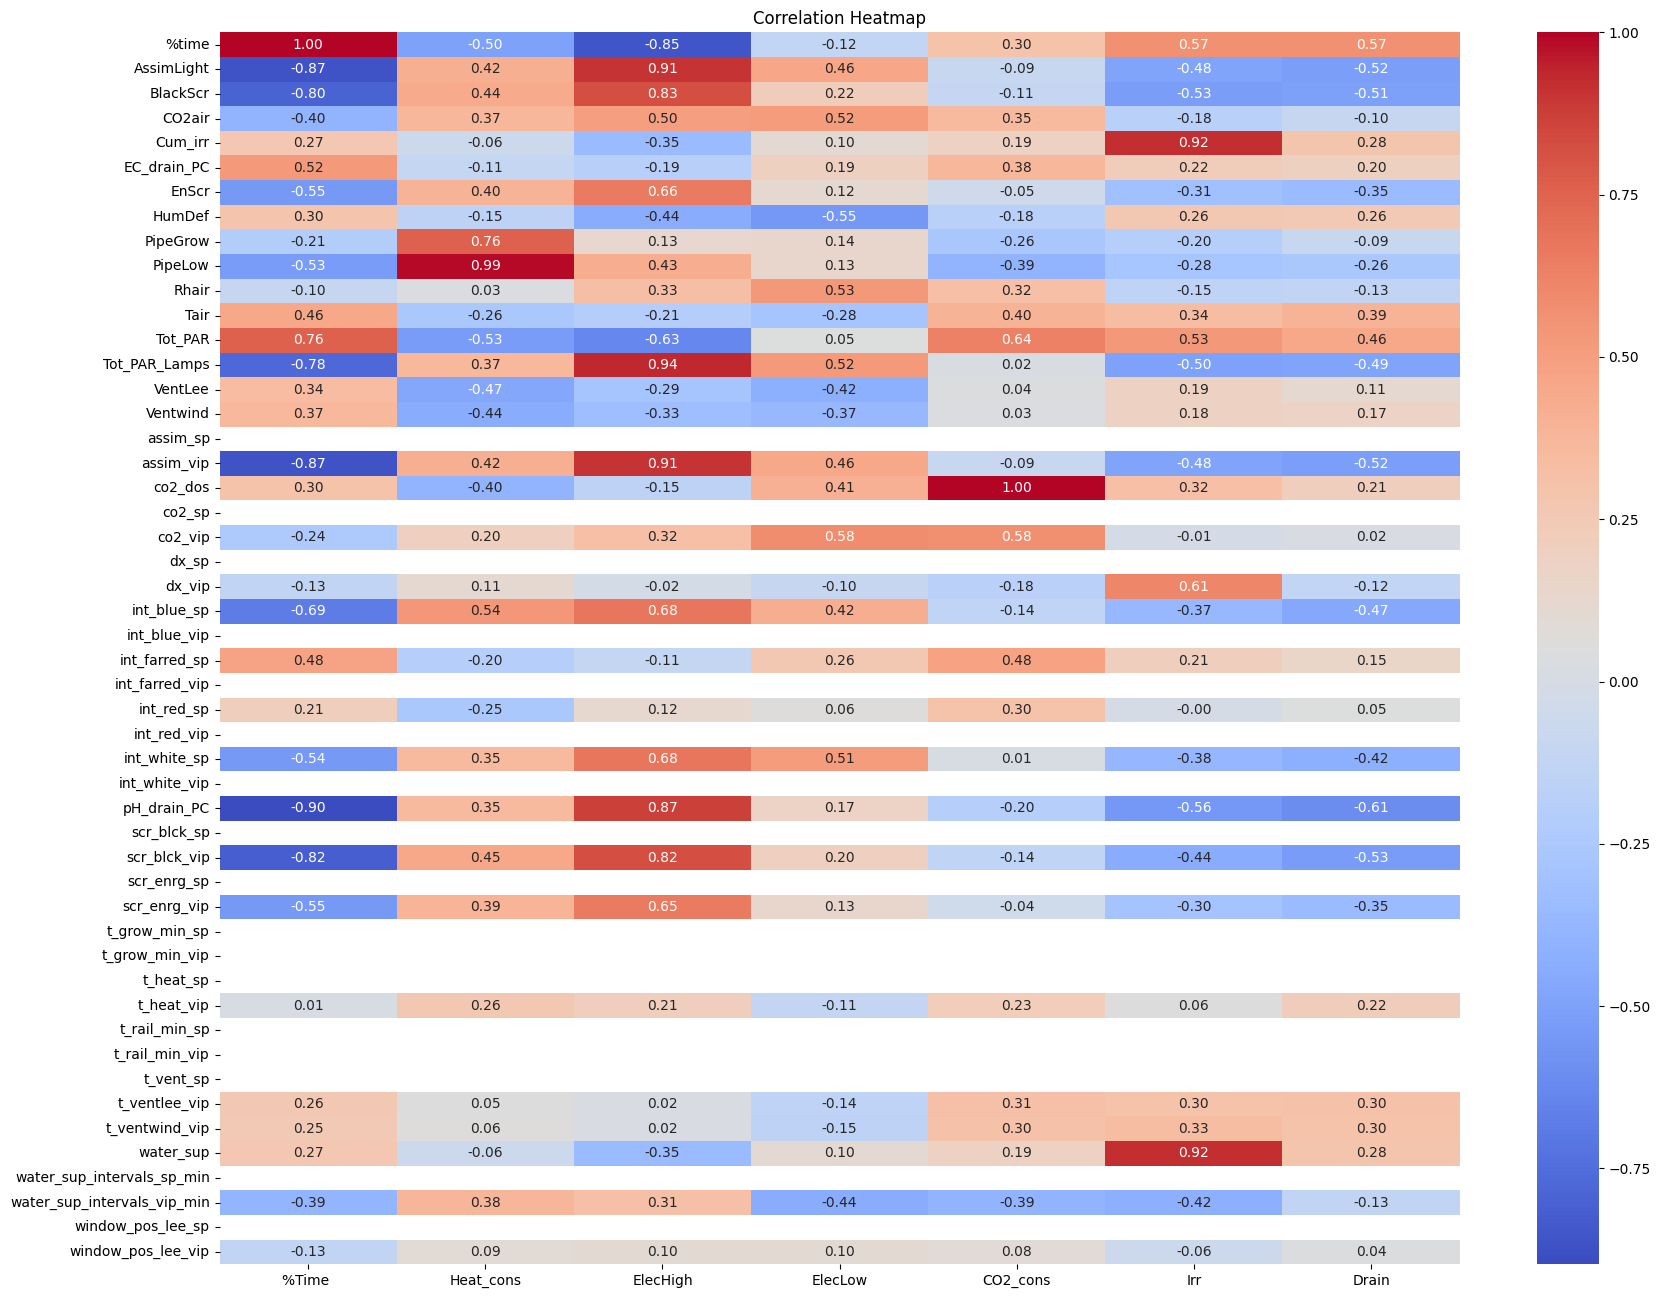

In [66]:
plt.figure(figsize=(20, 16))
corr_matrix = compute_correlation_matrix(df_climate_ag, resource)
# print(corr_matrix) # Từ đây có thể vẽ heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")

C:\Users\ntuan\AppData\Local\Temp\ipykernel_5508\2491269558.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(df_X[x_col], df_Y[y_col])
C:\Users\ntuan\AppData\Local\Temp\ipykernel_5508\2491269558.py:6: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, _ = pearsonr(df_X[x_col], df_Y[y_col])


Text(0.5, 1.0, 'Correlation Heatmap')

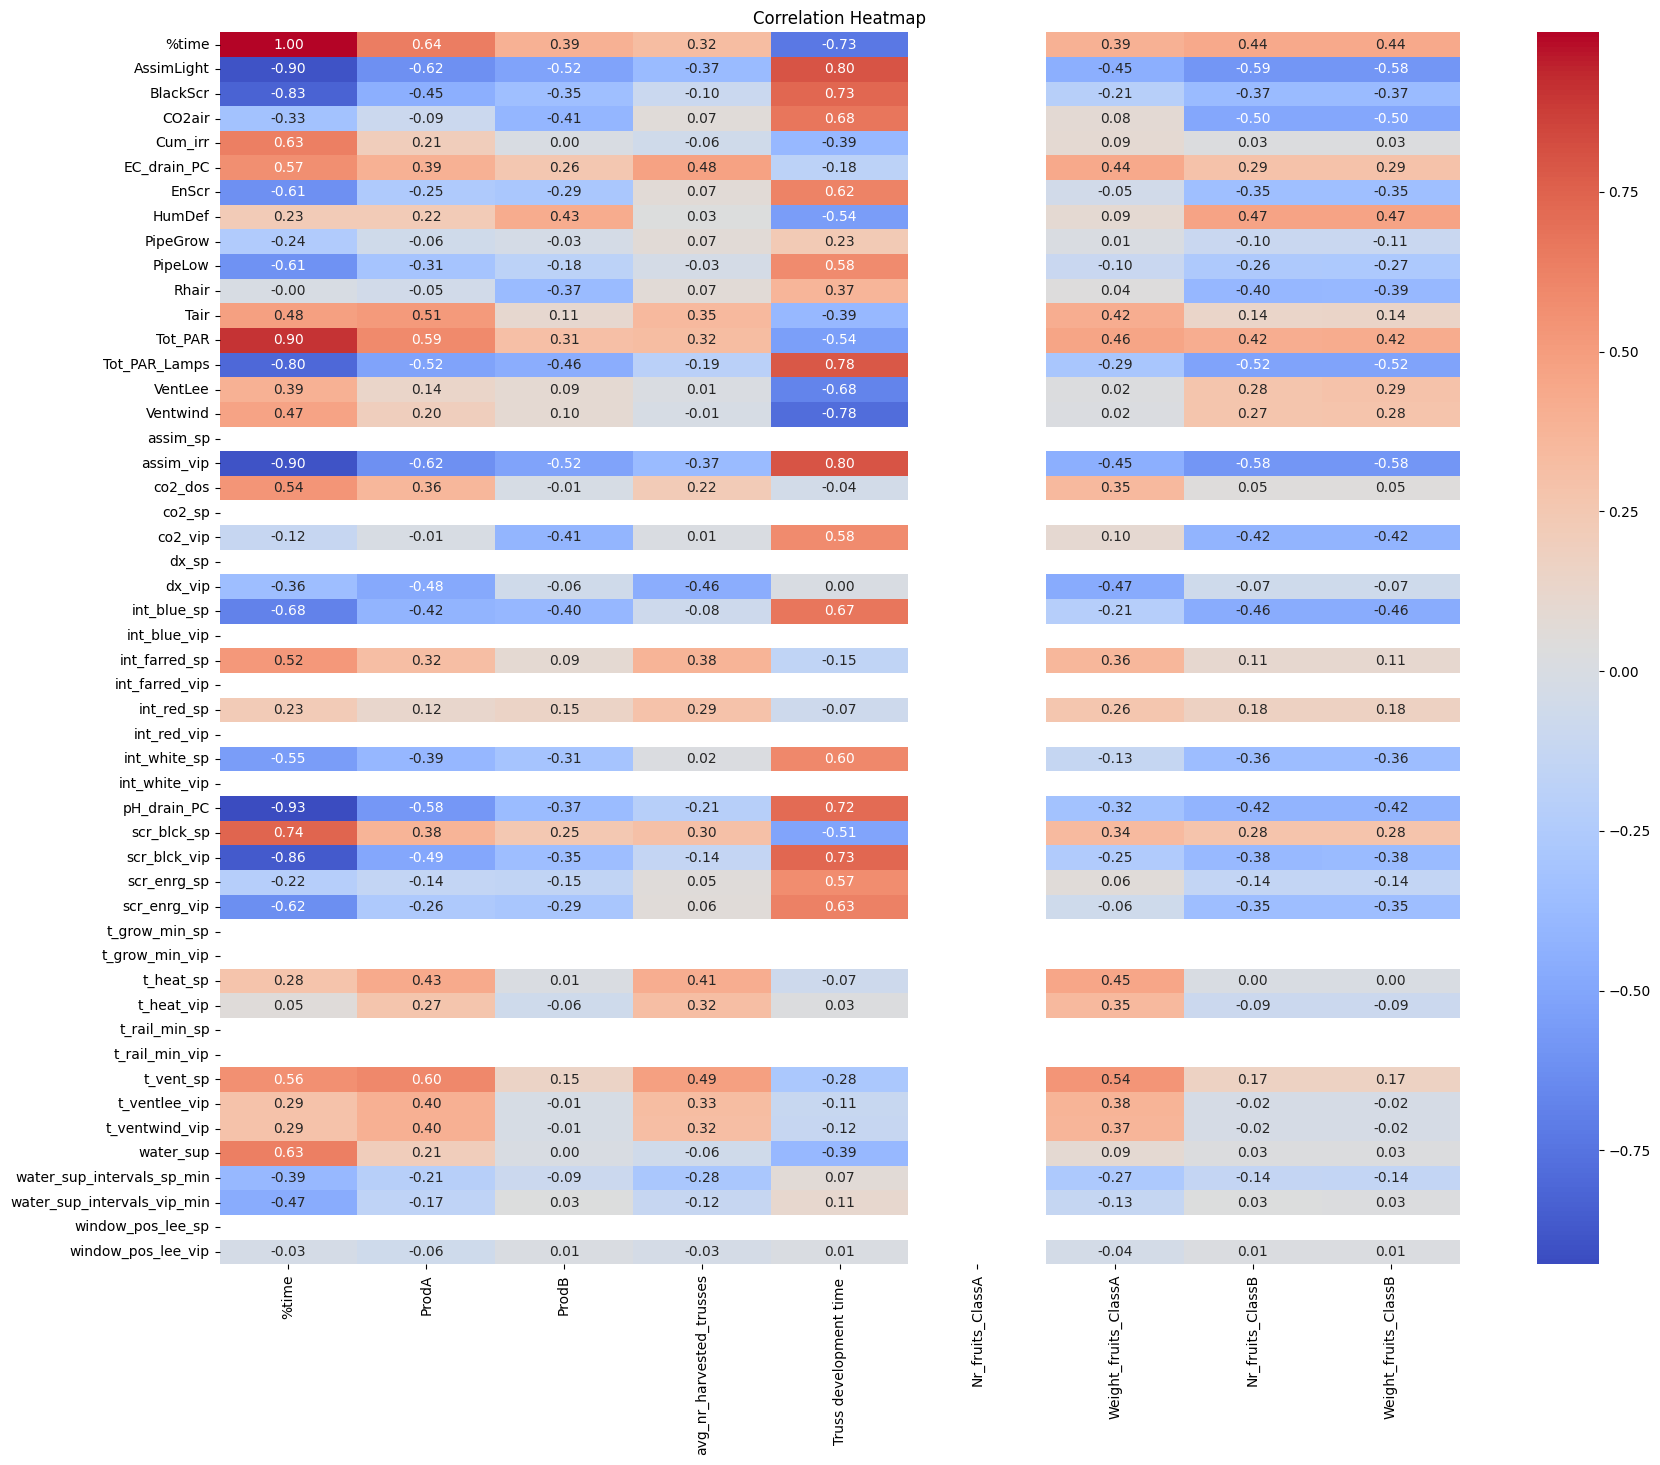

In [67]:
plt.figure(figsize=(20, 16))
corr_matrix = compute_correlation_matrix(df_climate, production)
# print(corr_matrix) # Từ đây có thể vẽ heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")

In [68]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Giả định bạn đã có: weather (DataFrame), resource (DataFrame)
train_features = climate.drop(columns=["%time", "int_blue_vip", "int_farred_vip", "int_red_vip", "int_white_vip"])
# --- Tham số ---
sample_per_day = 288  # 5 phút
N_days = len(climate) // sample_per_day

# --- Tạo chuỗi dữ liệu ---
X_seq = []
for i in range(N_days):
    start = i * sample_per_day
    end = start + sample_per_day
    X_seq.append(train_features.iloc[start:end].values)

X_seq = np.array(X_seq)  # Shape: (N_days, 288, N_weather)

# --- Chọn chỉ 1 cột từ resource ---
y = resource["Heat_cons"].values.reshape(-1, 1)  # Shape: (N_days, 1)

# --- Chuẩn hóa ---
scaler_X = StandardScaler()
X_seq_scaled = np.array([scaler_X.fit_transform(day) for day in X_seq])
X_seq_scaled = np.nan_to_num(X_seq_scaled)  # xử lý NaN nếu có

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)
y_scaled = np.nan_to_num(y_scaled)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_seq_scaled, y_scaled, test_size=0.2, random_state=42)

# --- Tạo mô hình LSTM ---
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Dự đoán 1 feature
])

lstm_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# --- Huấn luyện ---
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# --- Dự đoán ---
y_pred_scaled = lstm_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# --- Đánh giá ---
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² score: {r2:.4f}")


c:\Users\ntuan\miniconda3\envs\tf-2.10\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ntuan\miniconda3\envs\tf-2.10\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\ntuan\miniconda3\envs\tf-2.10\lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\ntuan\miniconda3\envs\tf-2.10\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ntuan\miniconda3\envs\tf-2.10\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\ntuan\miniconda3\envs\tf-2.10\lib\site-

Epoch 1/200
4/4 [==============================] - 2s 178ms/step - loss: 1.2355 - mae: 0.9049 - val_loss: 0.7746 - val_mae: 0.6928
Epoch 2/200
4/4 [==============================] - 0s 29ms/step - loss: 1.2023 - mae: 0.8589 - val_loss: 0.7607 - val_mae: 0.6899
Epoch 3/200
4/4 [==============================] - 0s 29ms/step - loss: 1.1807 - mae: 0.8629 - val_loss: 0.7469 - val_mae: 0.6850
Epoch 4/200
4/4 [==============================] - 0s 28ms/step - loss: 1.1666 - mae: 0.8609 - val_loss: 0.7370 - val_mae: 0.6831
Epoch 5/200
4/4 [==============================] - 0s 27ms/step - loss: 1.1431 - mae: 0.8504 - val_loss: 0.7247 - val_mae: 0.6771
Epoch 6/200
4/4 [==============================] - 0s 27ms/step - loss: 1.0900 - mae: 0.8164 - val_loss: 0.7126 - val_mae: 0.6703
Epoch 7/200
4/4 [==============================] - 0s 26ms/step - loss: 1.0541 - mae: 0.8029 - val_loss: 0.7006 - val_mae: 0.6633
Epoch 8/200
4/4 [==============================] - 0s 27ms/step - loss: 0.9164 - mae: 0.7

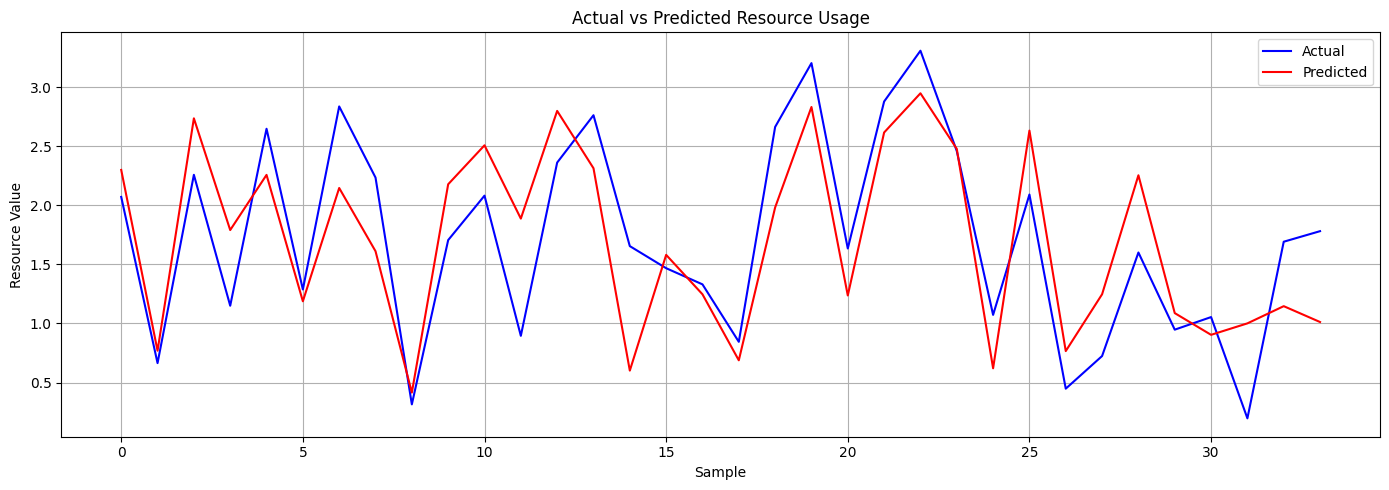

In [69]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ actual vs predicted
plt.figure(figsize=(14, 5))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Resource Usage')
plt.xlabel('Sample')
plt.ylabel('Resource Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


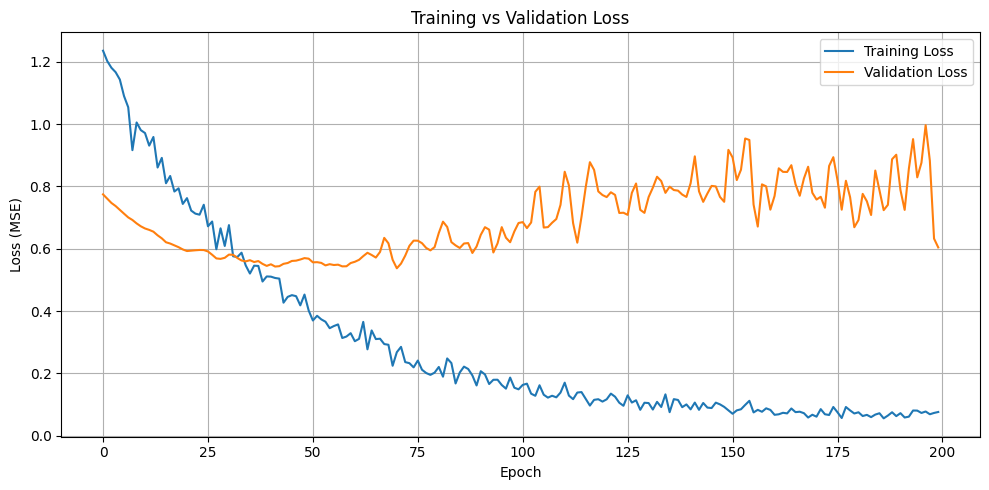

In [70]:
# Trích xuất loss từ history
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/200
7/7 [==============================] - 1s 26ms/step - loss: 5.1708 - mae: 1.6653 - val_loss: 0.6542 - val_mae: 0.6550
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 0.9986 - mae: 0.8329 - val_loss: 0.6546 - val_mae: 0.6449
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 0.9140 - mae: 0.7961 - val_loss: 0.6086 - val_mae: 0.6269
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 0.8104 - mae: 0.7592 - val_loss: 0.5763 - val_mae: 0.6161
Epoch 5/200
7/7 [==============================] - 0s 8ms/step - loss: 0.7338 - mae: 0.7198 - val_loss: 0.5446 - val_mae: 0.6067
Epoch 6/200
7/7 [==============================] - 0s 9ms/step - loss: 0.6659 - mae: 0.6797 - val_loss: 0.5243 - val_mae: 0.5998
Epoch 7/200
7/7 [==============================] - 0s 9ms/step - loss: 0.6112 - mae: 0.6350 - val_loss: 0.5219 - val_mae: 0.6049
Epoch 8/200
7/7 [==============================] - 0s 8ms/step - loss: 0.5745 - mae: 0.6186 - va

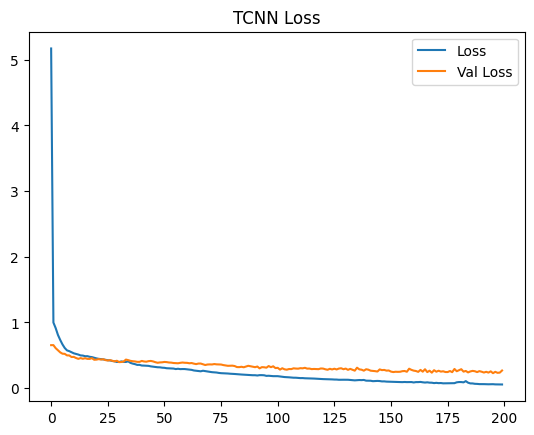

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D

Tcnn_model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

Tcnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = Tcnn_model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2, verbose=1)


# Evaluate
y_pred = Tcnn_model.predict(X_train).reshape(-1)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np, matplotlib.pyplot as plt

print("TCNN Metrics:")
print("MAE:", mean_absolute_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))
print("R²:", r2_score(y_train, y_pred))

# Plot
plt.plot(history.history['loss'], label='Loss'), plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(), plt.title("TCNN Loss")
plt.show()


In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_scaled = Tcnn_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² score: {r2:.4f}")


2/2 [==============================] - 0s 2ms/step
MAE: 0.3374
MSE: 0.1915
R² score: 0.7257


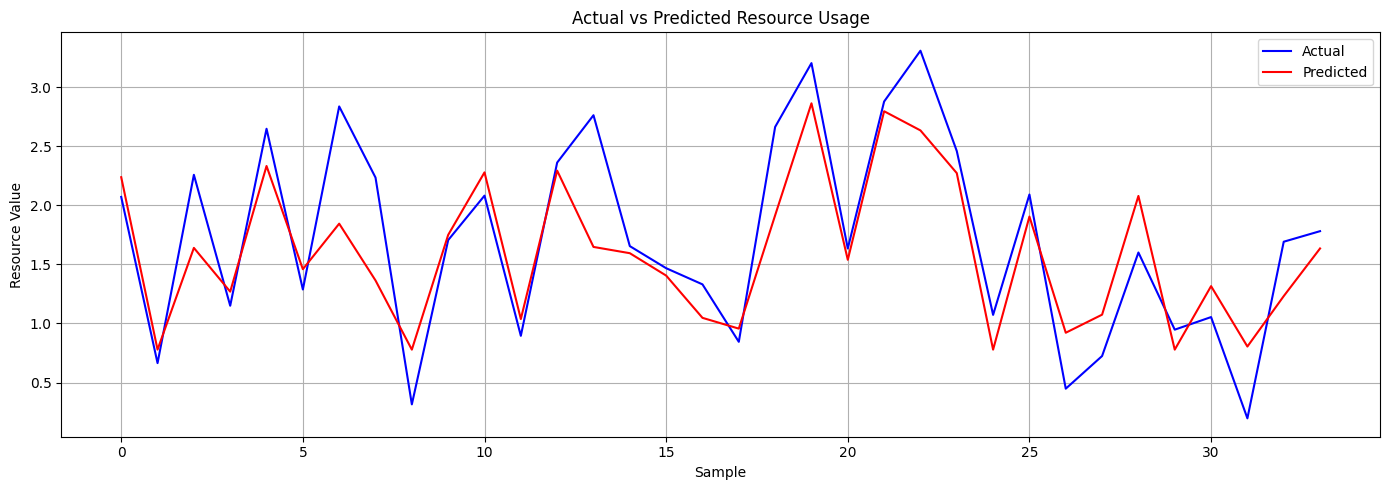

In [73]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ actual vs predicted
plt.figure(figsize=(14, 5))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Resource Usage')
plt.xlabel('Sample')
plt.ylabel('Resource Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

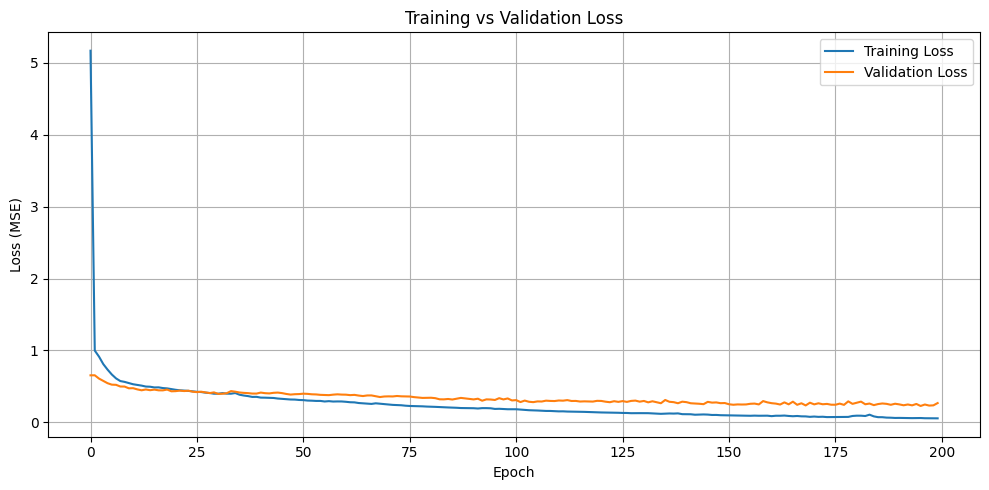

In [74]:
# Trích xuất loss từ history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/200
7/7 [==============================] - 3s 128ms/step - loss: 1.0164 - mae: 0.7894 - val_loss: 0.6662 - val_mae: 0.6361
Epoch 2/200
7/7 [==============================] - 0s 47ms/step - loss: 0.7019 - mae: 0.6498 - val_loss: 0.7307 - val_mae: 0.6691
Epoch 3/200
7/7 [==============================] - 0s 50ms/step - loss: 0.5924 - mae: 0.5982 - val_loss: 0.6929 - val_mae: 0.6495
Epoch 4/200
7/7 [==============================] - 0s 50ms/step - loss: 0.4725 - mae: 0.5244 - val_loss: 0.7101 - val_mae: 0.6620
Epoch 5/200
7/7 [==============================] - 0s 50ms/step - loss: 0.3871 - mae: 0.4850 - val_loss: 1.1239 - val_mae: 0.8498
Epoch 6/200
7/7 [==============================] - 0s 49ms/step - loss: 0.3387 - mae: 0.4386 - val_loss: 0.6193 - val_mae: 0.5870
Epoch 7/200
7/7 [==============================] - 0s 50ms/step - loss: 0.3710 - mae: 0.4659 - val_loss: 0.6060 - val_mae: 0.5960
Epoch 8/200
7/7 [==============================] - 0s 50ms/step - loss: 0.3527 - mae: 0.4

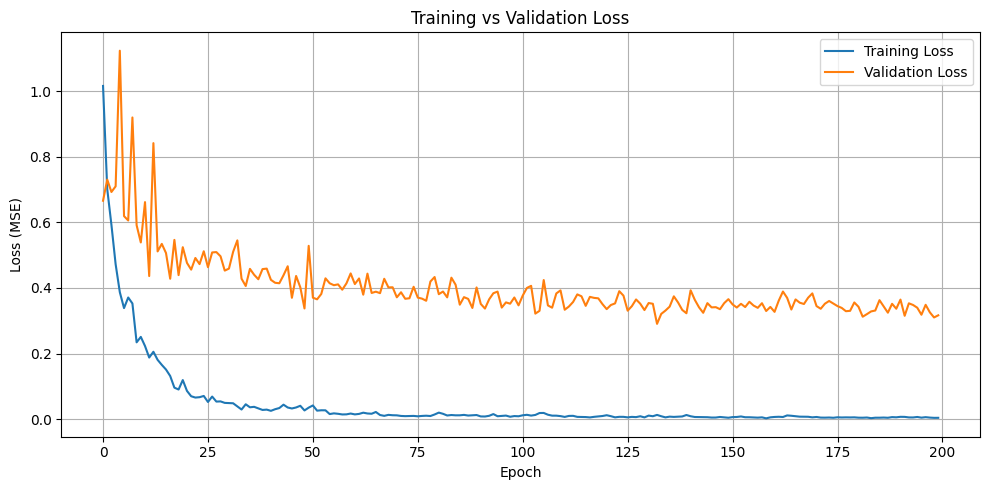

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

Gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64),
    Dense(64, activation='relu'),
    Dense(1)
])

Gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = Gru_model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2, verbose=1)

y_pred = Gru_model.predict(X_train).reshape(-1)
print("GRU Metrics:")
print("MAE:", mean_absolute_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))
print("R²:", r2_score(y_train, y_pred))
# Trích xuất loss từ history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/200
5/5 [==============================] - 1s 69ms/step - loss: 1.0104 - mae: 0.8236 - val_loss: 1.0622 - val_mae: 0.8035
Epoch 2/200
5/5 [==============================] - 0s 32ms/step - loss: 0.9655 - mae: 0.7995 - val_loss: 1.0592 - val_mae: 0.7917
Epoch 3/200
5/5 [==============================] - 0s 32ms/step - loss: 0.9280 - mae: 0.7744 - val_loss: 1.0535 - val_mae: 0.7760
Epoch 4/200
5/5 [==============================] - 0s 32ms/step - loss: 0.9008 - mae: 0.7446 - val_loss: 1.0492 - val_mae: 0.7650
Epoch 5/200
5/5 [==============================] - 0s 33ms/step - loss: 0.8319 - mae: 0.7022 - val_loss: 0.9819 - val_mae: 0.7351
Epoch 6/200
5/5 [==============================] - 0s 32ms/step - loss: 0.7551 - mae: 0.6479 - val_loss: 0.9593 - val_mae: 0.7210
Epoch 7/200
5/5 [==============================] - 0s 31ms/step - loss: 0.6941 - mae: 0.5865 - val_loss: 0.9300 - val_mae: 0.7005
Epoch 8/200
5/5 [==============================] - 0s 32ms/step - loss: 0.6428 - mae: 0.55

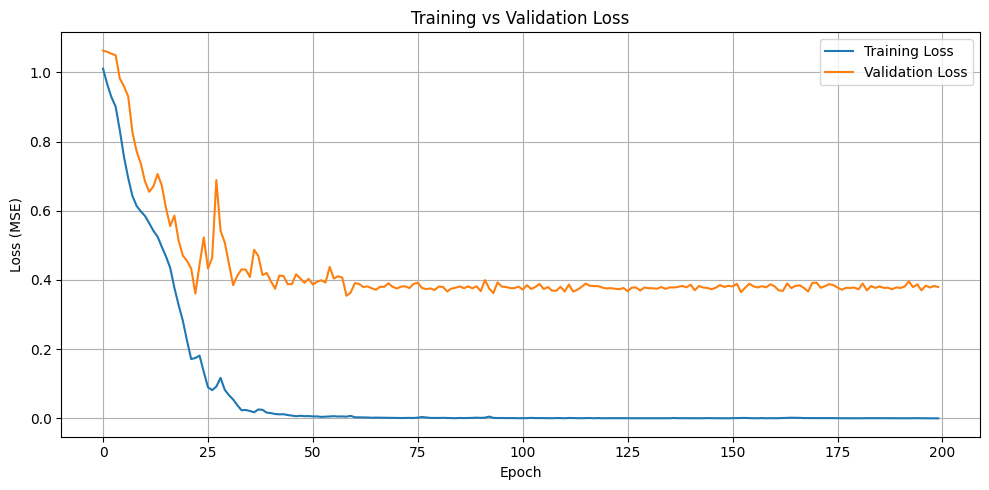

In [76]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LayerNormalization()(input_layer)
x = MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
x = Dropout(0.2)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1)(x)

Transformer_model = Model(inputs=input_layer, outputs=output)
Transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = Transformer_model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.5, verbose=1)

y_pred = Transformer_model.predict(X_train).reshape(-1)
print("Transformer Metrics:")
print("MAE:", mean_absolute_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))
print("R²:", r2_score(y_train, y_pred))
# Trích xuất loss từ history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Transformer_model.save("Transformer_model.h5")

In [82]:
train_features = test_climate.drop(columns=["%time", "int_blue_vip", "int_farred_vip", "int_red_vip", "int_white_vip"])
# --- Tham số ---
sample_per_day = 288  # 5 phút
N_days = len(test_climate) // sample_per_day

# --- Tạo chuỗi dữ liệu ---
X_seq = []
for i in range(N_days):
    start = i * sample_per_day
    end = start + sample_per_day
    X_seq.append(train_features.iloc[start:end].values)

X_seq = np.array(X_seq)  # Shape: (N_days, 288, N_weather)

# --- Chọn chỉ 1 cột từ resource ---
y = test_resource["Heat_cons"].values.reshape(-1, 1)  # Shape: (N_days, 1)

# --- Chuẩn hóa ---
scaler_X = StandardScaler()
X_seq_scaled = np.array([scaler_X.fit_transform(day) for day in X_seq])
X_seq_scaled = np.nan_to_num(X_seq_scaled)  # xử lý NaN nếu có

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)
y_scaled = np.nan_to_num(y_scaled)

y_pred = Tcnn_model.predict(X_seq_scaled).reshape(-1)
print("Transformer Metrics:")
print("MAE:", mean_absolute_error(y_scaled, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_scaled, y_pred)))
print("R²:", r2_score(y_scaled, y_pred))


c:\Users\ntuan\miniconda3\envs\tf-2.10\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ntuan\miniconda3\envs\tf-2.10\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\ntuan\miniconda3\envs\tf-2.10\lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\ntuan\miniconda3\envs\tf-2.10\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ntuan\miniconda3\envs\tf-2.10\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\ntuan\miniconda3\envs\tf-2.10\lib\site-

6/6 [==============================] - 0s 19ms/step
Transformer Metrics:
MAE: 0.8654705119115499
RMSE: 0.9856676626542344
R²: 0.02845925879773825


2/2 [==============================] - 0s 15ms/step
MAE: 0.4867
MSE: 0.4911
R² score: 0.5277


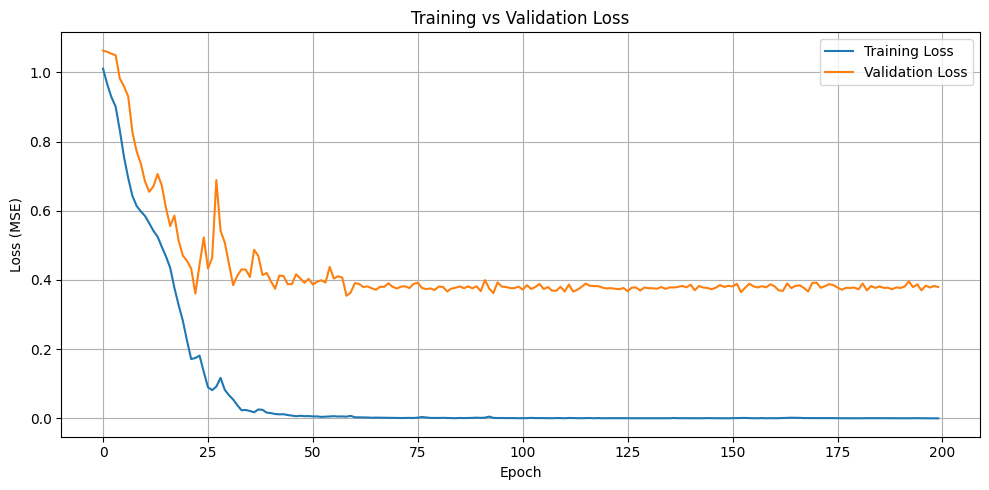

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_scaled = Transformer_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² score: {r2:.4f}")
# Trích xuất loss từ history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


XGBoost Metrics:
MAE: 0.0020587040968037497
RMSE: 0.004864950849283927
R²: 0.9999771989927582


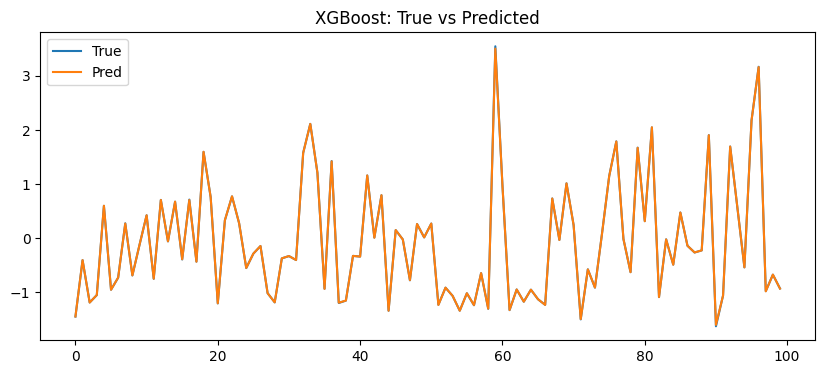

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Reshape data: [samples, time_steps, features] → [samples, time_steps * features]
X_train_xgb = X_train.reshape((X_train.shape[0], -1))
y_train_xgb = y_train.reshape(-1)

# Train model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_xgb, y_train_xgb)

# Predict
y_pred = xgb_model.predict(X_train_xgb)

# Metrics
print("XGBoost Metrics:")
print("MAE:", mean_absolute_error(y_train_xgb, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train_xgb, y_pred)))
print("R²:", r2_score(y_train_xgb, y_pred))

# Plot
plt.figure(figsize=(10,4))
plt.plot(y_train_xgb[:100], label='True')
plt.plot(y_pred[:100], label='Pred')
plt.title("XGBoost: True vs Predicted")
plt.legend()
plt.show()
